# Satellite image classification using VGG16

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img

/home/vitaliy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Global parameters
image_size = 256
train_folder = "Images/train/"
test_folder = "Images/test/"
train_batchsize = 64
val_batchsize = 16

In [4]:
def create_model_with_additional_layers(model_name, image_size):
    if model_name == "vgg16":
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "vgg19":
        pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "xception":
        pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "resnet50":
        pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "inceptionV3":
        pretrained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "inceptionresnetV2":
        pretrained_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "mobilenet":
        pretrained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
    else:
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    # Freeze all the layers
    for layer in pretrained_model.layers[:]:
        layer.trainable = False
    # Check the trainable status of the individual layers
    for layer in pretrained_model.layers:
        print(layer, layer.trainable)
    # Create the model
    model = models.Sequential()
    # Add the vgg convolutional base model
    model.add(pretrained_model)
    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(21, activation='softmax'))
    # Show a summary of the model. Check the number of trainable parameters
    print(model.summary())
    return model

In [5]:
def create_model_with_retrainable_layers(model_name, image_size):
    if model_name == "vgg16":
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "vgg19":
        pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "xception":
        pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "resnet50":
        pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    elif model_name == "inceptionV3":
        pretrained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    else:
        pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Freeze all the layers
    for layer in pretrained_model.layers[:-4]:
        layer.trainable = False

    # Check the trainable status of the individual layers
    for layer in pretrained_model.layers:
        print(layer, layer.trainable)

    # Create the model
    model = models.Sequential()
    # Add the vgg convolutional base model
    model.add(pretrained_model)
    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(21, activation='softmax'))
    # Show a summary of the model. Check the number of trainable parameters
    print(model.summary())
    return model

In [6]:
def train_model(model, train_folder, test_folder, train_batchsize, val_batchsize, image_size, filename,
                epochs = 3,classmode='categorical', lr=1e-4):
    # No Data augmentation
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Data Generator for Training data
    train_generator = train_datagen.flow_from_directory(
            train_folder,
            target_size=(image_size, image_size),
            batch_size=train_batchsize,
            class_mode=classmode)

    # Data Generator for Validation data
    validation_generator = validation_datagen.flow_from_directory(
            test_folder,
            target_size=(image_size, image_size),
            batch_size=val_batchsize,
            class_mode=classmode,
            shuffle=False)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=lr),
                  metrics=['acc'])

    # Train the Model
    history = model.fit_generator(
      train_generator, train_generator.n // train_batchsize, epochs=epochs, workers=4,
        validation_data=validation_generator, validation_steps=validation_generator.n // val_batchsize)

    # Save the Model
    model.save(filename)
    return model, history

In [7]:
def plot_training_process(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [8]:
from random import randint

def show_result(model, test_folder, image_size, classmode='categorical'):
    validation_datagen = ImageDataGenerator(rescale=1. / 255)

    # Create a generator for prediction
    validation_generator = validation_datagen.flow_from_directory(
        test_folder,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

    # Get the filenames from the generator
    fnames = validation_generator.filenames

    # Get the ground truth from generator
    ground_truth = validation_generator.classes

    # Get the label to class mapping from the generator
    label2index = validation_generator.class_indices

    # Getting the mapping from class index to class label
    idx2label = dict((v, k) for k, v in label2index.items())

    # Get the predictions from the model using the generator
    predictions = model.predict_generator(validation_generator,
                                          steps=validation_generator.samples / validation_generator.batch_size,
                                          verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    errors = np.where(predicted_classes != ground_truth)[0]
    print("No of errors = {}/{}".format(len(errors), validation_generator.samples))

    # Show the errors
    for i in range(5):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = load_img('{}/{}'.format(test_folder, fnames[errors[i]]))
        plt.figure(figsize=[7, 7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

# Experiment 1. Use model with imagenet weight, add more layers and retrain them for our data

In [9]:
model_vgg16 = create_model_with_additional_layers(model_name="vgg16", image_size=image_size)

<keras.engine.topology.InputLayer object at 0x7f1881b484a8> False
<keras.layers.convolutional.Conv2D object at 0x7f19257bd710> False
<keras.layers.convolutional.Conv2D object at 0x7f18f27105c0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1881b447b8> False
<keras.layers.convolutional.Conv2D object at 0x7f1881b26198> False
<keras.layers.convolutional.Conv2D object at 0x7f1881b48d68> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1881841438> False
<keras.layers.convolutional.Conv2D object at 0x7f1881869710> False
<keras.layers.convolutional.Conv2D object at 0x7f1881869048> False
<keras.layers.convolutional.Conv2D object at 0x7f1881814588> False
<keras.layers.pooling.MaxPooling2D object at 0x7f18817be358> False
<keras.layers.convolutional.Conv2D object at 0x7f18817e8160> False
<keras.layers.convolutional.Conv2D object at 0x7f18817e8c88> False
<keras.layers.convolutional.Conv2D object at 0x7f188178ef60> False
<keras.layers.pooling.MaxPooling2D object at 0x7f18817a7240> Fa

In [11]:
model_trained_vgg16, history_vgg16 = train_model(epochs=20, lr=1e-4, model=model_vgg16, train_folder=train_folder, test_folder=test_folder, train_batchsize=train_batchsize, val_batchsize=val_batchsize, image_size=image_size, filename="vgg16_add_layers.h5")

Found 6803 images belonging to 21 classes.
Found 1600 images belonging to 21 classes.
Epoch 1/20
106/106 [==============================] - 67s 631ms/step - loss: 1.1585 - acc: 0.6641 - val_loss: 0.5896 - val_acc: 0.8113
Epoch 2/20
106/106 [==============================] - 63s 594ms/step - loss: 0.4089 - acc: 0.8705 - val_loss: 0.5291 - val_acc: 0.8206
Epoch 3/20
106/106 [==============================] - 63s 594ms/step - loss: 0.2361 - acc: 0.9185 - val_loss: 0.5577 - val_acc: 0.8450
Epoch 4/20
106/106 [==============================] - 63s 595ms/step - loss: 0.1569 - acc: 0.9489 - val_loss: 0.6177 - val_acc: 0.8213
Epoch 5/20
106/106 [==============================] - 63s 596ms/step - loss: 0.1178 - acc: 0.9650 - val_loss: 0.4512 - val_acc: 0.8669
Epoch 6/20
106/106 [==============================] - 63s 594ms/step - loss: 0.0845 - acc: 0.9729 - val_loss: 0.3892 - val_acc: 0.8888
Epoch 7/20
106/106 [==============================] - 63s 594ms/step - loss: 0.0593 - acc: 0.9805 - val_

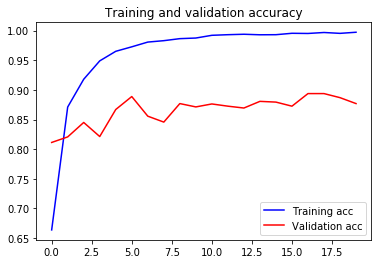

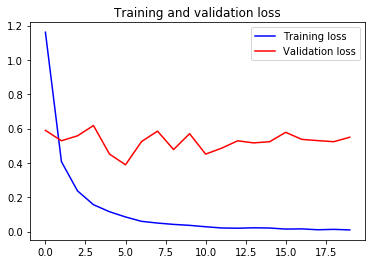

In [15]:
plot_training_process(history=history_vgg16)

Found 1600 images belonging to 21 classes.
100/100 [==============================] - 12s 123ms/step
No of errors = 197/1600


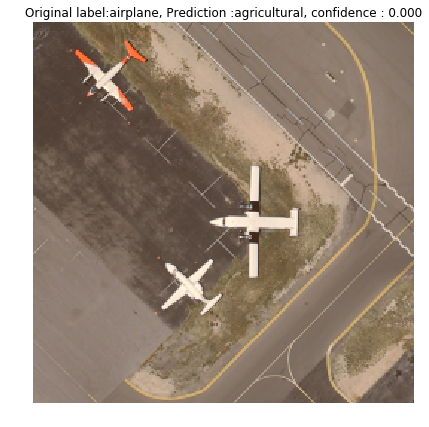

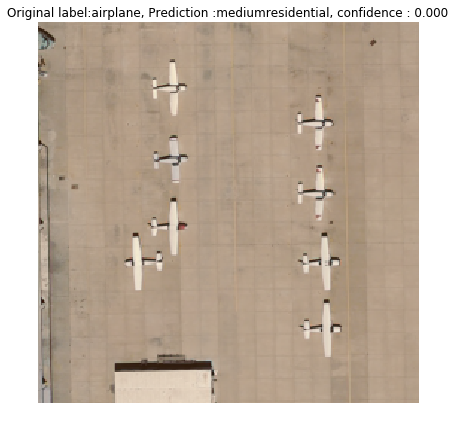

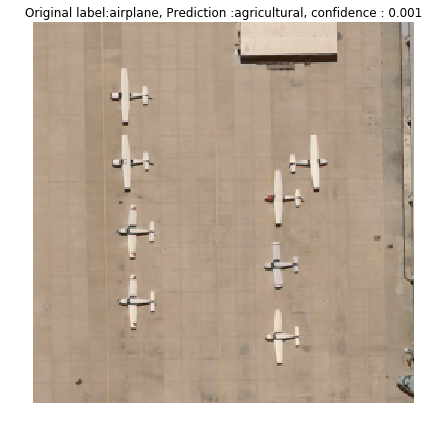

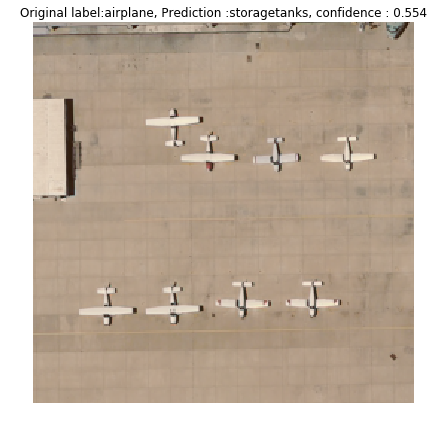

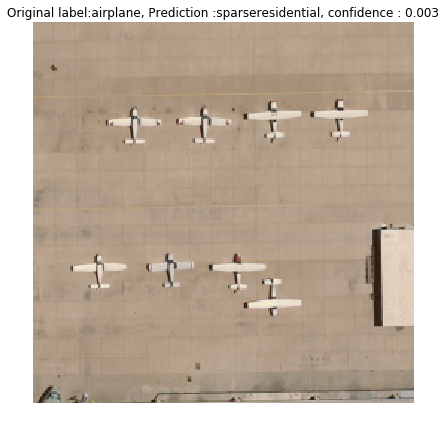

In [18]:
show_result(model_trained_vgg16, test_folder=test_folder, image_size=image_size)

# Experiment 2. Retrain last 4 layers in VGG 16  

In [19]:
model_vgg16_retrainable_layers = create_model_with_retrainable_layers("vgg16", image_size=image_size)

<keras.engine.topology.InputLayer object at 0x7f188054f240> False
<keras.layers.convolutional.Conv2D object at 0x7f16b4ebe3c8> False
<keras.layers.convolutional.Conv2D object at 0x7f16b4a5c470> False
<keras.layers.pooling.MaxPooling2D object at 0x7f16b4af3550> False
<keras.layers.convolutional.Conv2D object at 0x7f16b4e66160> False
<keras.layers.convolutional.Conv2D object at 0x7f16b4e66eb8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f16b4e4c5f8> False
<keras.layers.convolutional.Conv2D object at 0x7f16b4b72a58> False
<keras.layers.convolutional.Conv2D object at 0x7f16b4d87748> False
<keras.layers.convolutional.Conv2D object at 0x7f16b4d8b8d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f16b4f185f8> False
<keras.layers.convolutional.Conv2D object at 0x7f16b4b02908> False
<keras.layers.convolutional.Conv2D object at 0x7f16b4b02fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f16b4c242b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f16b4b9c470> Fa

In [20]:
model_trained_vgg16_retrainable_layers, history_vgg16_retrainable_layers = train_model(epochs=5, lr=1e-4, model=model_vgg16_retrainable_layers, train_folder=train_folder,
            test_folder=test_folder, train_batchsize=train_batchsize, val_batchsize=val_batchsize, image_size=image_size,
                                                     filename="vgg16_lats4.h5")

Found 6803 images belonging to 21 classes.
Found 1600 images belonging to 21 classes.
Epoch 1/5
106/106 [==============================] - 71s 666ms/step - loss: 1.3676 - acc: 0.5923 - val_loss: 0.7460 - val_acc: 0.7881
Epoch 2/5
106/106 [==============================] - 70s 662ms/step - loss: 0.2917 - acc: 0.9077 - val_loss: 0.5169 - val_acc: 0.8275
Epoch 3/5
106/106 [==============================] - 69s 653ms/step - loss: 0.1337 - acc: 0.9564 - val_loss: 0.4578 - val_acc: 0.8688
Epoch 4/5
106/106 [==============================] - 70s 659ms/step - loss: 0.0850 - acc: 0.9724 - val_loss: 0.4331 - val_acc: 0.8881
Epoch 5/5
106/106 [==============================] - 70s 659ms/step - loss: 0.0868 - acc: 0.9828 - val_loss: 0.4438 - val_acc: 0.8969


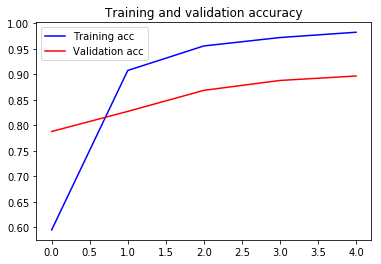

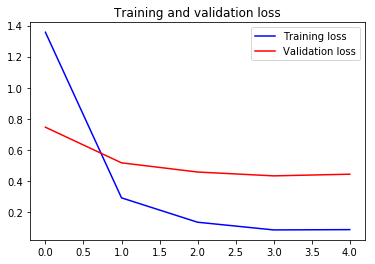

In [21]:
plot_training_process(history_vgg16_retrainable_layers)show_result(model=model_trained_vgg16_retrainable_layers, image_size=image_size, test_folder=test_folder)

Found 1600 images belonging to 21 classes.
100/100 [==============================] - 12s 123ms/step
No of errors = 165/1600


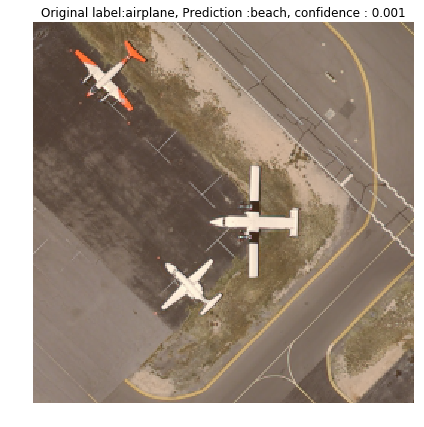

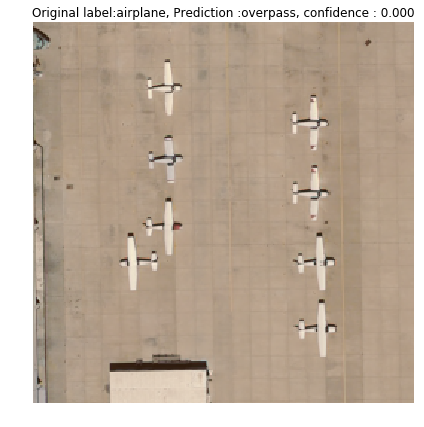

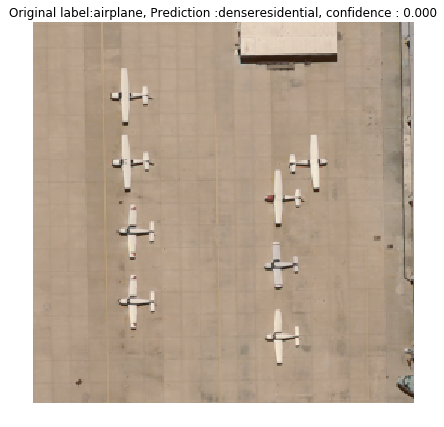

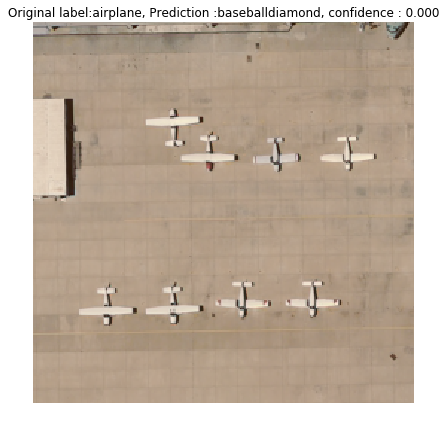

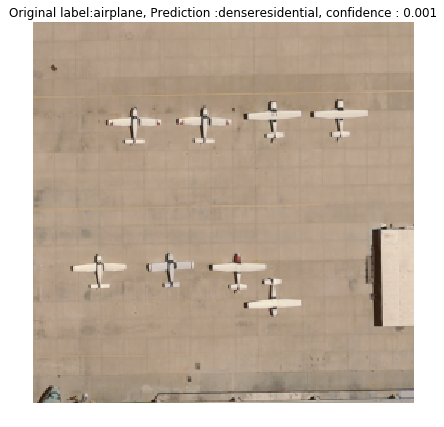

In [22]:
show_result(model=model_trained_vgg16_retrainable_layers, image_size=image_size, test_folder=test_folder)